In [1]:
from s3ts.data.tasks.download import download_dataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from s3ts.experiments.common import prepare_dms
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

/home/raul/code/s3ts/s3ts_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

In [3]:
# setup to recreate the folds used in the experiments

dataset = "SyntheticControl"
random_state = 0
fold, total_folds = 0, 5
dir_cache=Path("../cache/")

X, Y, mapping = download_dataset(dataset_name=dataset, dir_cache=dir_cache)
#X, _, Y, _ = train_test_split(X, Y, stratify=Y, test_size=0.9, random_state=0)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
for j, (train_index, test_index) in enumerate(skf.split(X, Y)):
  if j == fold:
    X_train, Y_train = X[train_index,:], Y[train_index]
    X_test, Y_test = X[test_index,:], Y[test_index]

train_dm, pretrain_dm = prepare_dms(dataset=dataset,
  X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test,
  batch_size=128, window_length=5, window_stride=1, rho_dfs=0.1, pret_frac=1 - 1/(total_folds-1), 
  quant_shifts=[0], quant_intervals=5, fold_number=fold, 
  random_state=random_state, frames=True, dir_cache=dir_cache)

In [4]:
train_dm.ds_train[1]

(tensor([[[ 0.1029,  0.3894,  0.3443,  0.6110,  0.8343],
          [-1.7018, -1.7460, -1.4676, -1.5100, -1.5173],
          [-1.7532, -1.5298, -1.8036, -1.5890, -1.4160],
          ...,
          [ 3.7230,  3.5649,  3.4521,  3.1099,  2.8203],
          [ 4.0215,  3.8965,  3.4235,  3.5563,  3.2332],
          [ 4.0751,  3.9388,  3.5322,  3.3526,  3.2509]],
 
         [[-2.4245, -2.3700, -2.2338, -2.1957, -2.1878],
          [-2.4616, -2.3686, -2.2709, -2.1943, -2.1507],
          [-2.4551, -2.4971, -2.2558, -2.3044, -2.3079],
          ...,
          [ 3.4731,  3.1869,  3.1305,  2.2024,  1.9593],
          [ 3.5011,  3.3510,  3.0457,  2.3573,  2.0855],
          [ 3.5112,  3.3626,  3.1952,  2.4742,  2.1736]],
 
         [[-0.1206,  0.0447,  0.0563,  0.2100,  0.3426],
          [-0.0516,  0.1138,  0.1253,  0.2791,  0.4116],
          [-0.0498,  0.1155,  0.1271,  0.2808,  0.4134],
          ...,
          [ 0.6152,  0.4825,  0.5200,  0.3800,  0.2894],
          [ 0.7800,  0.6476,  0.6829,

In [5]:
pretrain_dm.DFS_train

tensor([[[3.7923e-01, 1.5996e+00, 2.9347e+00,  ..., 3.0125e+01,
          2.9139e+01, 2.9256e+01],
         [2.5262e+00, 3.3674e+00, 4.7024e+00,  ..., 2.5057e+01,
          2.6029e+01, 2.5603e+01],
         [3.4068e+00, 4.1671e+00, 5.1372e+00,  ..., 2.3091e+01,
          2.2871e+01, 2.2723e+01],
         ...,
         [7.7825e+01, 7.5808e+01, 7.4116e+01,  ..., 1.2914e+01,
          1.3738e+01, 1.3272e+01],
         [7.8116e+01, 7.6042e+01, 7.4262e+01,  ..., 1.3679e+01,
          1.2488e+01, 1.3319e+01],
         [7.9331e+01, 7.7246e+01, 7.5410e+01,  ..., 1.2220e+01,
          1.2744e+01, 1.2396e+01]],

        [[1.5939e+00, 3.9832e+00, 6.4431e+00,  ..., 2.2518e+01,
          2.3033e+01, 2.2167e+01],
         [3.0247e+00, 3.8201e+00, 6.1231e+00,  ..., 2.2004e+01,
          2.2375e+01, 2.1695e+01],
         [5.0588e+00, 5.8004e+00, 6.7265e+00,  ..., 2.2416e+01,
          2.2978e+01, 2.1973e+01],
         ...,
         [7.8590e+01, 7.6555e+01, 7.4868e+01,  ..., 1.5646e+01,
          1.666

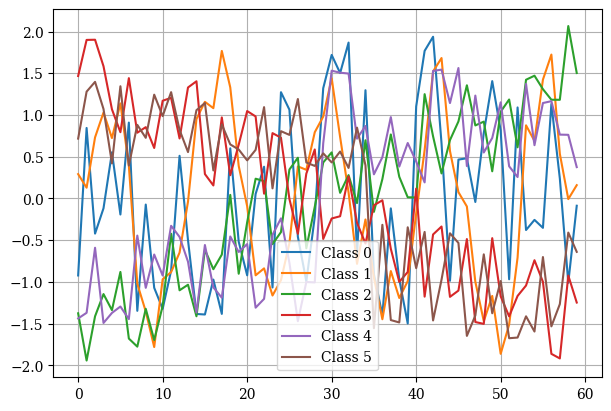

In [6]:
plt.figure(figsize=(6,4), layout="constrained")
for i in range(train_dm.patterns.shape[0]):
    plt.plot(train_dm.patterns[i], label=f"Class {i}")
plt.grid(True)
plt.legend();

/tmp/ipykernel_57749/761194953.py:23: RuntimeWarning: overflow encountered in exp
  exp_func = lambda t,a,b: a*np.exp(-b*t)


27


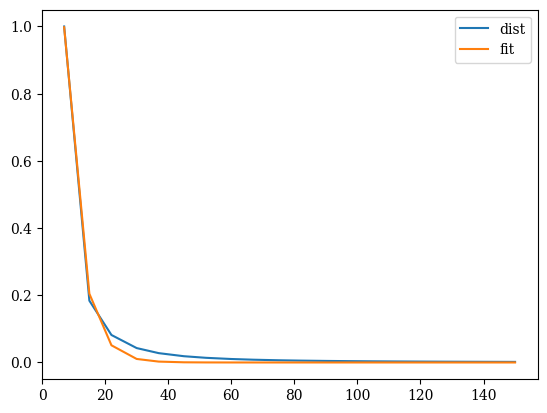

In [7]:
from sktime.distances import dtw_distance
from scipy.interpolate import splev, splrep

pattern = 1

dist = []
samples = np.linspace(train_dm.patterns.shape[1]/20, train_dm.patterns.shape[1], 20, dtype=int)
for i in samples:
    x = np.arange(train_dm.patterns.shape[1])
    series = train_dm.patterns[pattern].numpy()

    spl = splrep(x, series)

    x_comp = np.linspace(0,train_dm.patterns.shape[1], num=i)
    series_comp = splev(x_comp, spl)
    dist.append(dtw_distance(x, x_comp))
dist = np.array(dist)
dist = dist/dist.max()
plt.plot(samples, dist, label="dist")

from scipy.optimize import curve_fit

exp_func = lambda t,a,b: a*np.exp(-b*t)
popt, pcov = curve_fit(exp_func, samples, dist)

plt.plot(samples, exp_func(samples, *popt), label="fit")
plt.legend()
optimal = int(8*np.log(2)/popt[1])
print(optimal)

415.97633136094714


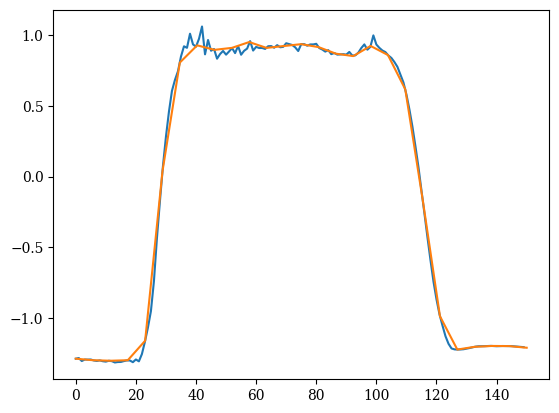

In [8]:
x = np.arange(train_dm.patterns.shape[1])
series = train_dm.patterns[pattern].numpy()

spl = splrep(x, series)

x_comp = np.linspace(0,train_dm.patterns.shape[1], num=optimal)
series_comp = splev(x_comp, spl)

plt.plot(x, series)
plt.plot(x_comp, series_comp)
print(dtw_distance(x, x_comp))

In [9]:
def smooth_STS(
        STS: np.ndarray,
        n_sample: int,
        l_sample: int,
        ) -> np.ndarray:

    STS = pd.Series(STS)
    XD = pd.Series(STS).rolling(5).mean()

    positions = np.arange(0,n_sample)*l_sample
    #print(positions)

    spacing = int(l_sample/10)
    
    for idx in positions[1:]:

        # moving averages
        


        # # using splinesss
        # idx_range = [
        #     idx-spacing,
        #     idx-spacing+1, 
        #     idx+spacing-2,
        #     idx+spacing-1,
        #     ]
        # series = [
        #     XD.iloc[idx-spacing],
        #     XD.iloc[idx-spacing+1],
        #     XD.iloc[idx+spacing-2],
        #     XD.iloc[idx+spacing-1]
        #     ]
        # spl = splrep(idx_range, series)
        # idx_range = np.arange(idx-spacing, idx+spacing)
        # STS.iloc[idx-spacing:idx+spacing] = splev(idx_range, spl)


        pass


    return STS.values

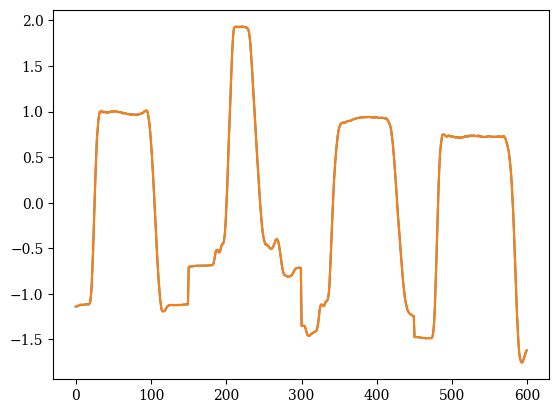

In [10]:
dm = pretrain_dm
TS = dm.STS_train
LP = dm.l_patterns
NS = int(dm.STS_train.shape[0]/LP)

samples = 4

plt.plot(TS[0:samples*LP])
plt.plot(smooth_STS(TS, NS, LP)[0:samples*LP])

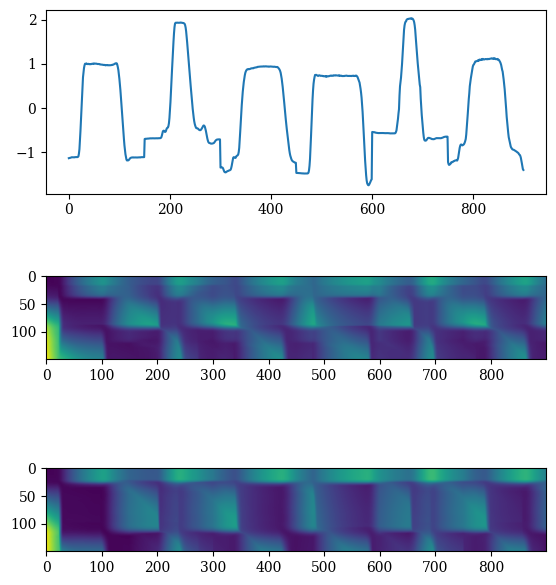

In [11]:
dm = pretrain_dm

TS = dm.STS_train
DFS = dm.DFS_train
CLS = dm.labels_train.argmax(dim=1)
NCLS = dm.n_labels
LP = dm.l_patterns
NP = dm.n_patterns

samples = 6

fig = plt.figure(figsize=(6, 2*(NP+1)), dpi=100, layout="constrained")
gs = fig.add_gridspec(nrows=NP+1, ncols=2,
    hspace=0, height_ratios=None,
    wspace=0, width_ratios=[0.1, 0.9])

axes = {}

axes["TS"] = fig.add_subplot(gs[0,1])
axes["TS"].plot(TS[0:samples*LP])

for i in range(NP):
    axes[i] = fig.add_subplot(gs[i+1,1])
    axes[i].imshow(DFS[i,:,0:samples*LP])


In [12]:
NCLS

5